In [34]:
#При необходимости установите библиотеку
#pip install pandasql

In [35]:
#импортируем библиотеки
import pandas as pd
from pandasql import sqldf
import warnings
import numpy as np
import seaborn as sns

# Обработка данных

In [36]:
#выгружаем .xlsx файлы в pandas фреймы
with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    customers = pd.read_excel("customer_info.xlsx")
    transactions = pd.read_excel("transactions_info.xlsx")

In [37]:
#Информация о атрибутах таблицы customers
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2429 entries, 0 to 2428
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id_client              2429 non-null   int64  
 1   Total_amount           2429 non-null   float64
 2   Gender                 2365 non-null   object 
 3   Age                    2394 non-null   float64
 4   Count_city             2429 non-null   int64  
 5   Response_communcation  2429 non-null   int64  
 6   Communication_3month   2429 non-null   int64  
 7   Tenure                 2429 non-null   int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 151.9+ KB


In [38]:
#Информация о атрибутах таблицы transactions
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419122 entries, 0 to 419121
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date_new        419122 non-null  datetime64[ns]
 1   Id_check        419122 non-null  int64         
 2   Count_products  419122 non-null  float64       
 3   Sum_payment     419122 non-null  float64       
 4   ID_client       419122 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 16.0 MB


In [39]:
#визуальный осмотр данных таблицы transactions
transactions.head(10)

,date_new,Id_check,Count_products,Sum_payment,ID_client
0,2016-03-01,2271145,2.034,23.31,104027
1,2016-03-01,2271145,1.000,31.75,104027
2,2016-03-01,2271145,1.000,6.80,104027
3,2016-03-01,2271145,1.000,6.24,104027
4,2016-03-01,2271145,1.000,36.98,104027
5,2016-03-01,2271145,1.000,10.93,104027
6,2016-03-01,2271145,1.000,60.96,104027
7,2016-03-01,2271145,1.000,72.17,104027
8,2016-03-01,2271145,1.000,60.96,104027
9,2015-07-01,1771932,1.000,2.15,112005


In [40]:
#присвоен индекс фрейма в качестве уникального id таблицы transactions
transactions = transactions.reset_index().rename(columns = {"index":"tr_id"})

In [41]:
#приведен к единому наименованию связующий таблицы столбец ID_client
customers.rename(columns = {"Id_client":"ID_client"}, inplace = True)

# Первое задание

In [42]:
#количество уникальных периодов отмеченных в таблице transactions
unique_dates = sqldf("SELECT count(*) as Amount_of_dates FROM( SELECT date_new FROM transactions GROUP BY date_new)")
unique_dates

,Amount_of_dates
0,13


### Результат

In [43]:
first_task = sqldf("""
                    SELECT ID_client,
                    ROUND(SUM(Sum_payment)/COUNT(DISTINCT Id_check), 1) as average_check,
                    ROUND(SUM(Sum_payment)/COUNT(DISTINCT date_new), 1) as average_monthly,
                    COUNT(*) as total_operations
                    FROM transactions
                    GROUP BY ID_client
                    HAVING COUNT(DISTINCT date_new) = 13
                    ORDER BY average_monthly DESC
                   """)
first_task

,ID_client,average_check,average_monthly,total_operations
0,16052,81.3,44898.3,65222
1,185364,179.3,1792.6,1489
2,193285,125.0,1577.4,2187
3,199886,110.0,1167.4,1536
4,194930,87.6,1091.4,1797
...,...,...,...,...
75,233877,79.8,202.7,300
76,228686,104.1,200.3,268
77,193868,78.2,180.5,309
78,185435,73.3,180.4,278


In [44]:
# 1. Список клиентов с неперерывной историей представлен по клиентам, у которых в каждом из 13 уникальных периодов есть операции
# 2. Средний чек по клиенту представлен как сумма всех операций клиента разделенная на количество чеков
# 3. Средняя сумма покупок в месяц рассчитана как сумма всех операций клиента разделенная на количество периодов (месяцев)
# 4. Количество операций по клиенту рассчитано как количество всех строк таблицы transactions по каждому клиенту

Клиент 16052 является выбросом из выборки, так как средний ежемесячный чек в 25 раз больше чем у следующего за ним по порядку клиента

# Второе задание

In [45]:
#заменяем пустые значения в столбце Gender таблицы Customers на флаг "N"
values = {"Gender":"N"}
customers.fillna(value=values, inplace = True)

In [46]:
#оцениваем распределение клиентов по гендеру
customers["Gender"].value_counts()

F    1598
M     767
N      64
Name: Gender, dtype: int64

### Результат

In [47]:
second_task = sqldf("""
                    SELECT SUBSTR(t.date_new, 6, 2) as Month,
                    ROUND(SUM(Sum_payment)/COUNT(DISTINCT Id_check), 1) as average_check,
                    COUNT(*)/COUNT(DISTINCT SUBSTR(t.date_new, 1, 7)) as average_operations,
                    COUNT(DISTINCT ID_client)/COUNT(DISTINCT SUBSTR(t.date_new, 1, 7)) as average_clients,
                    ROUND((1.0*COUNT(*))/(1.0*(SELECT COUNT(*) FROM transactions)),3) as share_of_total_operations,
                    ROUND(SUM(Sum_payment)/(SELECT SUM(Sum_payment) FROM transactions),3) as share_of_total_sum,
                    ROUND(sum(male)/sum(Sum_payment),3) as Male_share,
                    ROUND(sum(female)/sum(Sum_payment),3) as Female_share,
                    ROUND(sum(na)/sum(Sum_payment),3) as NA_share
                    FROM transactions as t
                    LEFT JOIN
                            (SELECT tr_id, t1.date_new, Sum_payment as male
                            FROM transactions as t1
                                LEFT JOIN customers as c on t1.ID_client = c.ID_client
                            WHERE Gender = 'M')M
                    ON t.tr_id = M.tr_id
                    LEFT JOIN
                            (SELECT tr_id, t2.date_new, Sum_payment as female
                            FROM transactions as t2
                                LEFT JOIN customers as c on t2.ID_client = c.ID_client
                            WHERE Gender = 'F')F
                    ON t.tr_id = F.tr_id
                    LEFT JOIN
                            (SELECT tr_id, t3.date_new, Sum_payment as na
                            FROM transactions as t3
                                LEFT JOIN customers as c on t3.ID_client = c.ID_client
                            WHERE Gender = 'N')N
                    ON t.tr_id = N.tr_id
                    GROUP BY SUBSTR(t.date_new, 6, 2)
                    """)
second_task

,Month,average_check,average_operations,average_clients,share_of_total_operations,share_of_total_sum,Male_share,Female_share,NA_share
0,01,90.2,30383,991,0.072,0.069,0.266,0.708,0.026
1,02,103.1,48174,1254,0.115,0.121,0.264,0.708,0.028
2,03,95.9,43268,1181,0.103,0.108,0.248,0.722,0.030
3,04,96.1,38770,1089,0.093,0.093,0.258,0.714,0.028
4,05,94.9,42952,1179,0.102,0.104,0.273,0.704,0.023
5,06,96.1,20519,605,0.098,0.099,0.254,0.717,0.029
6,07,93.8,29697,939,0.071,0.069,0.246,0.733,0.021
7,08,91.5,28891,907,0.069,0.066,0.214,0.762,0.024
8,09,93.2,28088,901,0.067,0.065,0.224,0.749,0.027
9,10,94.2,29674,967,0.071,0.070,0.246,0.733,0.021


In [48]:
# 1. Средняя сумма чека в месяц рассчитана как сумма всех операций по месяцу деленная на количество чеков
# 2. Среднее количество операций в месяц рассчитана как количество всех операций деленная на количество месяцев
# 3. Среднее количество клиентов, которые совершали операции, рассчитано как количество всех клиентов деленное на количество месяцев
# 4. Доля от общего количества операций за период рассчитана как количество операций за месяц деленная на полное количество операций
# 5. Доля от общей суммы операций за период рассчитана как сумма операций за месяц деленная на полную сумму операций
# 6. % от суммы операций по мужчинам, женщинам и пустым строкам распределен по столбцам

Средний чек ежемесячно находится на одном уровне 90-100, поэтому видим, что праздничные месяца не влияют на сумму чека.
Наблюдается рост среднего количества клиентов зимой и весной, кроме мая (февраль максимум - 1254, май минимум - 605)
Женщины составляют около 73% ежемесячной суммы оплат, мужчины - 24%

# Третье задание

In [49]:
#разбивка клиентов по возрастынм группам
ages = customers["Age"].sort_values().to_list()
age_group = []
step = 10
x = 1
for i in range(0, len(ages)):  
    if np.sum(ages[i]) != np.sum(ages[i]):
        age_group.append(0) #клиенты без информации о возрасте находятся в категории 0
    else:
        if ages[i]>=step: 
            x += 1
            age_group.append(x)
            step += 10
        else:
            age_group.append(x)

In [50]:
#Добавление ноового столбца Age_group в таблицу customers
customers["Age_group"] = age_group

In [51]:
#Распределение клиентов по возрастынм группам. Наибольшее количество клиентов в 3-4 группах (20-40 лет)
customers["Age_group"].value_counts()

3    570
4    560
5    437
6    410
7    231
8     85
2     84
0     35
1     11
9      6
Name: Age_group, dtype: int64

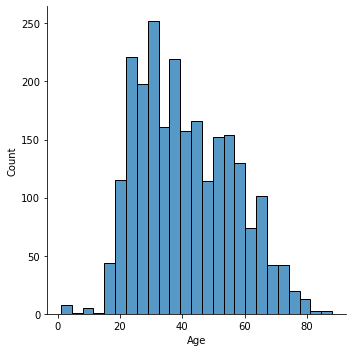

In [52]:
#График распределения клиентов по возрасту
sns.displot(data=customers, x="Age")

### Результат

In [53]:
third_task = sqldf("""
                    SELECT Age_group, 
                    COUNT(*) as Total_operations,
                    SUM(Sum_payment) as Total_payment,
                    ROUND((SUM(Sum_payment)/COUNT(DISTINCT SUBSTR(t.date_new, 1, 7)))*3,2) as average_payment_quarterly
                    FROM transactions as t
                    LEFT JOIN customers as c ON t.ID_client = c.ID_client
                    GROUP BY Age_group
                   """)
third_task

,Age_group,Total_operations,Total_payment,average_payment_quarterly
0,0,6549,64641.24,14917.21
1,1,1164,12047.81,2780.26
2,2,14129,131021.16,30235.65
3,3,85279,823043.48,189933.11
4,4,82623,781668.13,180384.95
5,5,52522,526764.92,121561.14
6,6,58713,560976.97,129456.22
7,7,101968,919942.23,212294.36
8,8,15473,150486.83,34727.73
9,9,702,7140.84,1647.89


In [54]:
# 1. Количество операций рассчитано как количество всех строк по возрастной группе
# 2. Сумма по операций рассчитана как сумма оплат по возрастной группе
# 3. Средняя ежеквартальная опалата рассчитана как сумма всех операций деленная на количество месяцев и умноженна на 3

Наибольший вклад в результат вносят 3 и 4 возрастные группы (20-40 лет) 

<AxesSubplot:xlabel='Age_group', ylabel='Total_payment'>

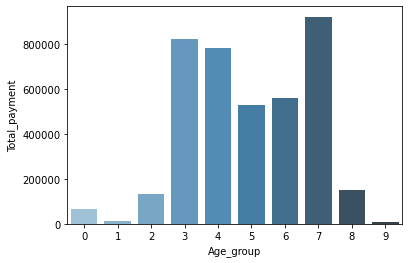

In [55]:
#график показывает сумму оплат по каждой возрастной группе
sns.barplot(data=third_task, x="Age_group", y="Total_payment", palette="Blues_d")